In [1]:
import icecube
from icecube import icetray, dataio
from icecube.icetray import I3Tray
import glob
import os
from datetime import datetime
import json
import csv
import matplotlib.pyplot as plt
import numpy as np

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<char, std::allocator<char> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<OMKey, std::allocator<OMKey> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<short, std::allocator<short> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignore

In [2]:
class CheckRandomness(icetray.I3Module):
    def __init__(self, ctx):
        icetray.I3Module.__init__(self,ctx)
        
        self.AddParameter("filters", "filters", None)
        self.AddParameter("minbias_list", "minbias_list", None)
        self.AddParameter("spefit_list", "spefit_list", None)

    def Configure(self):
        self.minbias_list = self.GetParameter("minbias_list")
        self.spefit_list = self.GetParameter("spefit_list")
        self.filters = self.GetParameter("filters")

        
    def Physics(self, frame):
        #if frame["I3EventHeader"].sub_event_stream == "NullSplit":
         #   filters = frame["FilterMask_NullSplit0"]
          #  minbias = filters["FilterMinBias_13"].condition_passed
           # self.minbias_list.append( (frame["I3EventHeader"].event_id, minbias) )
            #if "SPEFitSingle" in frame:
             #   self.spefit_list.append( (frame["I3EventHeader"].event_id, frame["SPEFitSingle"].dir.zenith, frame["SPEFitSingle"].dir.azimuth) )
        if frame["I3EventHeader"].sub_event_stream == "InIceSplit":
            filters_NullSplit0 = frame["FilterMask_NullSplit0"]
            filters = frame["FilterMask"]
            if filters_NullSplit0["FilterMinBias_13"].condition_passed and filters_NullSplit0["FilterMinBias_13"].prescale_passed:
                # if no other passed then throw away event
                any_true = False
                for key, item in filters.items():
                    if item.condition_passed and item.prescale_passed:
                        any_true = True
                        continue
                if not any_true:
                    return
            self.filters.append(filters)
            minbias = (filters["FilterMinBias_13"].condition_passed, filters["FilterMinBias_13"].prescale_passed)
            minbias0 = (filters["FilterMinBias_13"].condition_passed, filters["FilterMinBias_13"].prescale_passed)
            self.minbias_list.append( (frame["I3EventHeader"].event_id, minbias) )
            if "SPEFitSingle" in frame:
                self.spefit_list.append( (frame["I3EventHeader"].event_id, frame["SPEFitSingle"].dir.zenith, frame["SPEFitSingle"].dir.azimuth) )
        


In [3]:
path_trigger = "20904_examples/IC86.2020_corsika.020904.000001.i3.zst"
paths = ["first_trial/", "second_trial/", "third_trial/"]
minbias = {1: [], 2: [], 3: []}
spefit_single = {1: [], 2: [], 3: []}
filters = {1: [], 2: [], 3: []}
eventlist = {1: [], 2: [], 3: []}
for i, path in enumerate(paths):
    tray = I3Tray()
    tray.Add("I3Reader", filename=path+"L2_sanity_trial"+str(i+1)+".i3.gz")
    tray.Add(CheckRandomness, minbias_list = minbias[i+1], spefit_list = spefit_single[i+1], filters = filters[i+1])
    tray.Execute()


NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))
NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))
NOTICE (I3Tray): I3Tray finishing... (I3Tray.cxx:526 in void I3Tray::Execute(bool, unsigned int))


In [11]:
#print(minbias)
#print(spefit_single)


print("how many values in the minbias lists?")
for key, item in minbias.items():
    print("Trial", key, " has total nevents", len(item))
    print("Minbias filter:")
    print("condition pass", len([x for x in item if x[1][0] == True]))
    print("condition fail", len([x for x in item if x[1][0] == False]))
    print("prescale pass", len([x for x in item if x[1][1] == True]))
    print("prescale fail", len([x for x in item if x[1][1] == False]))
    print("\n")


# are any events different?
print("are any events different?")
flag = False
for trial1, trial2, trial3 in zip(minbias[1], minbias[2], minbias[3]):
    if trial1[0] != trial2[0] != trial3[0]:
        print("different events!")
        flag = True
        print(trial1[0], trial2[0], trial3[0])
if not flag:
    print("all events are the same\n\n")


print("how many values in the spefit lists?")
for key, item in spefit_single.items():
    print(key, len(item))
    
# are the lists sorted?
sorted = all(x[0] == y[0] == z[0] for x, y, z in zip(spefit_single[1],spefit_single[2],spefit_single[3]))
print("are the three lists sorted by event id?", sorted)

# compare event by event
for i in range(len(spefit_single[1])):
    azi_diff = abs(spefit_single[1][i][2] - spefit_single[2][i][2])
    zen_diff = abs(spefit_single[1][i][1] - spefit_single[2][i][1])
    eps = 1e-15
    if azi_diff > eps:
        print("oh no azi", azi_diff)
    if zen_diff > eps:
        print("oh no zen", zen_diff)


# compare event by event
for i in range(len(spefit_single[1])):
    azi_diff = abs(spefit_single[3][i][2] - spefit_single[2][i][2])
    zen_diff = abs(spefit_single[3][i][1] - spefit_single[2][i][1])
    eps = 1e-15
    if azi_diff > eps:
        print("oh no azi", azi_diff)
    if zen_diff > eps:
        print("oh no zen", zen_diff)

# compare event by event
for i in range(len(spefit_single[1])):
    azi_diff = abs(spefit_single[3][i][2] - spefit_single[1][i][2])
    zen_diff = abs(spefit_single[3][i][1] - spefit_single[1][i][1])
    eps = 1e-15
    if azi_diff > eps:
        print("oh no azi", azi_diff)
    if zen_diff > eps:
        print("oh no zen", zen_diff)

how many values in the minbias lists?
Trial 1  has total nevents 1764
Minbias filter:
condition pass 0
condition fail 1764
prescale pass 0
prescale fail 1764


Trial 2  has total nevents 1764
Minbias filter:
condition pass 0
condition fail 1764
prescale pass 0
prescale fail 1764


Trial 3  has total nevents 1764
Minbias filter:
condition pass 0
condition fail 1764
prescale pass 0
prescale fail 1764


are any events different?
all events are the same


how many values in the spefit lists?
1 1608
2 1608
3 1608
are the three lists sorted by event id? True


(array([   0.,    0.,    0.,    0.,    0., 1764.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

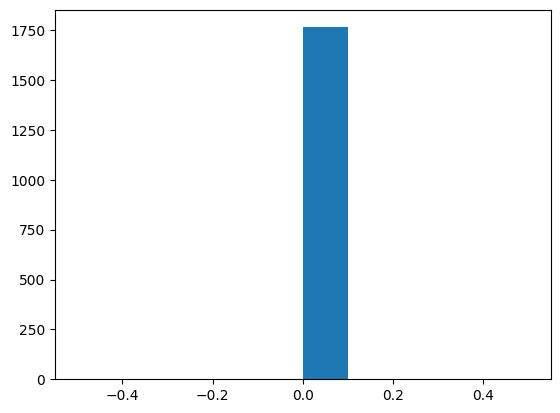

In [5]:
import matplotlib.pyplot as plt


x = [int(x[1][0]) for x in minbias[1]]
y = [int(y[1][1]) for y in minbias[1]]

plt.figure()
plt.hist(y)

In [6]:
print("filters")
counts = {1: {}, 2: {}, 3: {}}

for trial, list_of_dicts in filters.items():
    for filterevent in list_of_dicts:
        for key, item in filterevent.items():
            if key in counts[trial]:
                if counts[trial][key].condition_passed:
                    pass
        

counts = {}
for i in range(1,4):
    counts[i] = {key:[0, 0] for key, item in filters[1][0].items()}
    for filter in filters[i]:
        for key, item in filter.items():
            counts[i][key][0] += int(item.condition_passed)
            counts[i][key][1] += int(item.prescale_passed)

print(counts)

for key in counts[1].keys():
    print(key)
    print("condition passed")
    print(1, counts[1][key][0])
    print(2, counts[2][key][0])
    print(3, counts[3][key][0])
    print("prescale passed")
    print(1, counts[1][key][1])
    print(2, counts[2][key][1])
    print(3, counts[3][key][1])
    print("\n")

filters
{1: {'CascadeFilter_13': [185, 185], 'DMIceTrigFilter_22': [0, 0], 'DeepCoreFilter_13': [29, 29], 'EHEAlertFilterHB_15': [0, 0], 'EHEAlertFilter_15': [0, 0], 'EstresAlertFilter_18': [0, 0], 'FPFilter_23': [0, 0], 'FSSCandidate_13': [546, 0], 'FSSFilter_13': [403, 403], 'FilterMinBias_13': [0, 0], 'FixedRateFilter_13': [0, 0], 'GFUFilter_17': [0, 0], 'GRECOOnlineFilter_19': [0, 0], 'HESEFilter_15': [0, 0], 'HighQFilter_17': [75, 75], 'I3DAQDecodeException': [0, 0], 'IceActTrigFilter_18': [0, 0], 'IceTopSTA3_13': [0, 0], 'IceTopSTA5_13': [0, 0], 'IceTop_InFill_STA2_17': [0, 0], 'IceTop_InFill_STA3_13': [0, 0], 'IceTop_SouthwestNHLCTank1_22': [0, 0], 'InIceSMT_IceTopCoincidence_13': [0, 0], 'LowUp_13': [102, 102], 'MESEFilter_15': [60, 60], 'MonopoleFilter_16': [114, 114], 'MoonFilter_13': [453, 453], 'MuonFilter_13': [410, 410], 'OnlineL2Filter_17': [170, 170], 'SDST_IceTopSTA3_13': [0, 0], 'SDST_IceTop_InFill_STA3_13': [0, 0], 'SDST_InIceSMT_IceTopCoincidence_13': [0, 0], 'Scint